# LinkedIn Profile Analysis

We will build a supervised pipeline to classify a profile depending on a subset of tagged data.
Beyond the standard word cleanupfor an NLP pipeline, we should:
- remove hashtag, both word and symbol.
- remove email addresses.
- Symbols.

In [42]:
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

tqdm.pandas()

In [43]:
DATA = "./anonLinkedInProfiles.csv"
data = pd.concat([chunk for chunk in tqdm(pd.read_csv(DATA, chunksize=1000), desc=f'Loadin {DATA}')])
print(f'Shape: {data.shape}, does it have NAs:\n{data.isna().any()}')

data = data.dropna()
data = data.drop(data[(data['descriptions'] == '') | (data['titles'] == '')].index)

print(f'Post fill NAs:\n{data.isna().any()}')
data['class'] = data['class'].apply(lambda x: x.lower())

# For this exercise, keep it small.
data = data.sample(800)
data = data.reset_index() # Reset index, since we will do operations on it!
print(f'Resampled Shape: {data.shape}')

data.head()

Loadin ./anonLinkedInProfiles.csv: 0it [00:00, ?it/s]

Shape: (34993, 4), does it have NAs:
user            False
descriptions     True
titles           True
class           False
dtype: bool
Post fill NAs:
user            False
descriptions    False
titles          False
class           False
dtype: bool
Resampled Shape: (800, 5)


,index,user,descriptions,titles,class
0,1759,Bettye Joeckel,mobile app developer with experience in develo...,business manager,o
1,30890,Joseph Norton,blockchain trailblazer,inquisitive researcher with a passion for unco...,c
2,6262,Patricia Mccullough,analytical and resultsdriven operations analys...,analytical and resultsdriven operations analys...,o
3,1156,Eva Diga,founder master of disruption,leading the charge with a fearless attitude an...,w
4,15904,Susan Westberg,cryptocurrency analyst,i manage online communities and social media a...,c


In [44]:
import string
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin
from nltk.tokenize import sent_tokenize
from nltk.tokenize import ToktokTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
from nltk import pos_tag

nltk.download('all')

NGRAMS = (2,2) # BGrams only
STOP_WORDS = stopwords.words('english')
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”", "|", "#"]
COMMON_WORDS = [] # to be populated later in our analysis
toktok = ToktokTokenizer()
wnl = WordNetLemmatizer()

def _get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Creating our tokenizer function. Can also use a TFIDF
def custom_tokenizer(sentence):
    # Let's use some speed here.
    tokens = [toktok.tokenize(sent) for sent in sent_tokenize(sentence)]
    tokens = [wnl.lemmatize(word, _get_wordnet_pos(word)) for word in tokens[0]]
    tokens = [word.lower().strip() for word in tokens]
    tokens = [tok for tok in tokens if (tok not in STOP_WORDS and tok not in SYMBOLS and tok not in COMMON_WORDS)]

    return tokens

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


def clean_text(text):
    if (type(text) == str):
        text = text.strip().replace("\n", " ").replace("\r", " ")
        text = text.lower()
    else:
        text = "NA"
    return text


# With the BoW, the model does a bit better.
bow_vector = CountVectorizer(
    tokenizer=custom_tokenizer, ngram_range=NGRAMS)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/adarmani/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/adarmani/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/adarmani/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/adarmani/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/adarmani/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloadi

In [45]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

# Combine features for NLP.
X = data['titles'].astype(str) +  ' ' + data['descriptions'].astype(str)
ylabels = le.fit_transform(data['class'])

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

Let's look at the word frequencies by label, using our vectorizer - this is a slow process, but we want to see if the material for embeddings makes sense for the given class.

Anything that is too common, and irrelavant will be added to the COMMONWORDS list, and will be dropped in the vectorization step when building the model.

fn:fit:   0%|          | 0/800 [00:00<?, ?it/s]

/Users/adarmani/miniconda3/envs/hack2023/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


fn:transform:   0%|          | 0/800 [00:00<?, ?it/s]

fn:labels:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5361 [00:00<?, ?it/s]

Plot labels: 0it [00:00, ?it/s]

/var/folders/59/fz3bfjtx70g4bh0_0sh4klnw0000gq/T/ipykernel_6553/3436668919.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[y_plot][x_plot].set_yticklabels(y1, rotation=0)
/var/folders/59/fz3bfjtx70g4bh0_0sh4klnw0000gq/T/ipykernel_6553/3436668919.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[y_plot][x_plot].set_yticklabels(y1, rotation=0)
/var/folders/59/fz3bfjtx70g4bh0_0sh4klnw0000gq/T/ipykernel_6553/3436668919.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[y_plot][x_plot].set_yticklabels(y1, rotation=0)
/var/folders/59/fz3bfjtx70g4bh0_0sh4klnw0000gq/T/ipykernel_6553/3436668919.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[y_plot][x_plot].set_yticklabels(y1, rotation=0)
/var/folders/59/fz3bfjtx70g4bh0_0sh4klnw0000gq/T/ipykernel_6553/3436668919.py:57: UserWarning: FixedFormatter should only be used together with FixedLoc

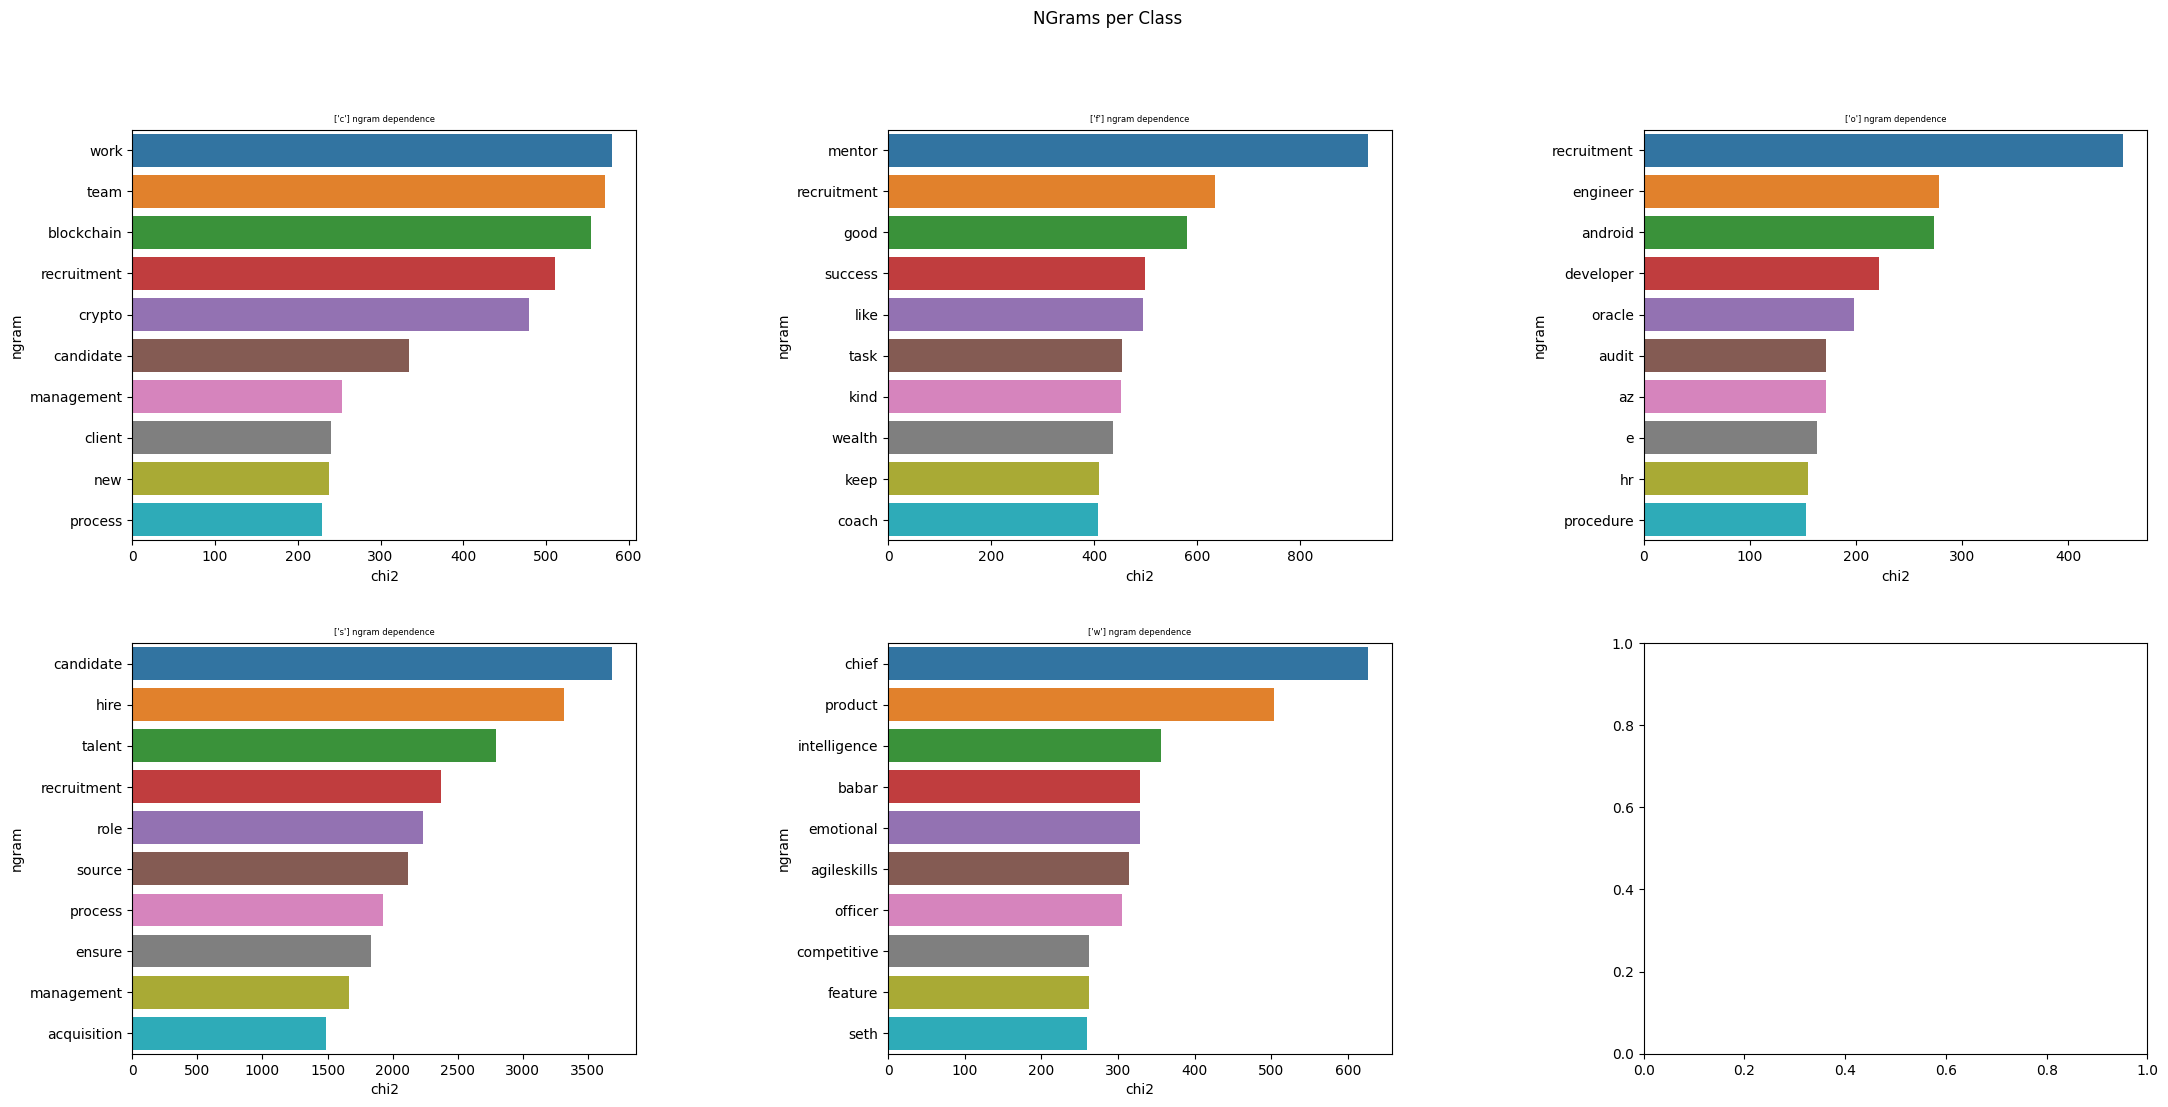

In [46]:
import seaborn as sns
from sklearn.feature_selection import chi2

def get_top_n_dependant_ngrams(corpus, corpus_labels, ngram=1, n=3):
    # use a private vectorizer.
    _vect = CountVectorizer(tokenizer=custom_tokenizer,
                            ngram_range=(ngram, ngram))
    vect = _vect.fit(tqdm(corpus, "fn:fit"))
    bow_vect = vect.transform(tqdm(corpus, "fn:transform"))
    features = bow_vect.toarray()

    labels = np.unique(corpus_labels)
    ngrams_dict = {}
    for label in tqdm(labels, "fn:labels"):
        corpus_label_filtered = corpus_labels == label
        features_chi2 = chi2(features, corpus_label_filtered)
        feature_names = np.array(_vect.get_feature_names_out())

        feature_rev_indices = np.argsort(features_chi2[0])[::-1]
        feature_rev_indices = feature_rev_indices[:n]
        ngrams = [(feature_names[idx], features_chi2[0][idx]) for idx in feature_rev_indices]
        ngrams_dict[label] = ngrams

    # while we are at it, let's return top N counts also
    sum_words = bow_vect.sum(axis=0)
    bottom_words_counts = [(word, sum_words[0, idx])
                  for word, idx in tqdm(_vect.vocabulary_.items())]
    top_words_counts = sorted(
        bottom_words_counts, key=lambda x: x[1], reverse=True)
    top_words_counts = top_words_counts[:n]
    bottom_words_counts= bottom_words_counts[:n]
        
    return {'labels_freq': ngrams_dict,
            'top_corpus_freq': top_words_counts,
            'bottom_corpus_freq': bottom_words_counts}


TOP_N_WORDS = 10

common_bigrams_label_dict = get_top_n_dependant_ngrams(X, ylabels, ngram=1, n=TOP_N_WORDS)

fig, axes = plt.subplots(2, 3, figsize=(26, 12), sharey=False)
fig.suptitle('NGrams per Class')
fig.subplots_adjust(hspace=0.25, wspace=0.50)

x_plot = 0
y_plot = 0
labels = np.sort(np.unique(ylabels), axis=None)
for idx, label in tqdm(enumerate(labels), "Plot labels"):
    common_ngrams_df = pd.DataFrame(
        common_bigrams_label_dict['labels_freq'][label], columns=['ngram', 'chi2'])
    x1, y1 = common_ngrams_df['chi2'], common_ngrams_df['ngram']

    # Reverse it from the ordinal label we transformed it.
    axes[y_plot][x_plot].set_title(
        f'{le.inverse_transform([label])} ngram dependence', fontsize=6)
    axes[y_plot][x_plot].set_yticklabels(y1, rotation=0)
    sns.barplot(ax=axes[y_plot][x_plot], x=x1, y=y1)
    # Go to next plot.
    if idx > 0 and idx % 2 == 0:
        x_plot = 0
        y_plot += 1
    else:
        x_plot += 1

plt.show()

In [47]:
print(common_bigrams_label_dict['top_corpus_freq'])
print(common_bigrams_label_dict['bottom_corpus_freq'])

[('work', 1529), ('team', 1425), ('recruitment', 1275), ('candidate', 835), ('new', 725), ('manager', 679), ('management', 672), ('business', 650), ('client', 607), ('product', 604)]
[('business', 650), ('manager', 679), ('mobile', 100), ('app', 39), ('developer', 185), ('experience', 539), ('develop', 242), ('deploy', 23), ('io', 13), ('android', 149)]


These most frequent or least frequent words don't have relevance to the individual classes, and are available in all text. We check if they these don't have high chi2 score though, as we don't want to alter the text's classification by removing a highly correlated but low frequency word.

In [48]:
common_label_freq = [word for label in labels for word, count in common_bigrams_label_dict['labels_freq'][label]]
print(f'Highest frequency of ngrames in labels: {common_label_freq}')

COMMON_WORDS = np.append([word for word,count in common_bigrams_label_dict['top_corpus_freq'] if word not in common_label_freq], 
                         [word for word,count in common_bigrams_label_dict['bottom_corpus_freq'] if word not in common_label_freq ])
COMMON_WORDS

Highest frequency of ngrames in labels: ['work', 'team', 'blockchain', 'recruitment', 'crypto', 'candidate', 'management', 'client', 'new', 'process', 'mentor', 'recruitment', 'good', 'success', 'like', 'task', 'kind', 'wealth', 'keep', 'coach', 'recruitment', 'engineer', 'android', 'developer', 'oracle', 'audit', 'az', 'e', 'hr', 'procedure', 'candidate', 'hire', 'talent', 'recruitment', 'role', 'source', 'process', 'ensure', 'management', 'acquisition', 'chief', 'product', 'intelligence', 'babar', 'emotional', 'agileskills', 'officer', 'competitive', 'feature', 'seth']


array(['manager', 'business', 'business', 'manager', 'mobile', 'app',
       'experience', 'develop', 'deploy', 'io'], dtype='<U10')

<function matplotlib.pyplot.show(close=None, block=None)>

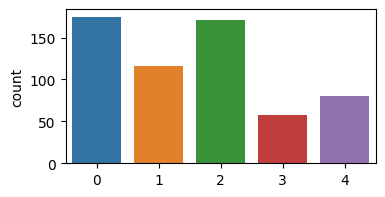

In [49]:
plt.figure(figsize=(4,2))
sns.countplot(x=y_train)
plt.show

Since our training dataset is unbalanced, we need to resample to least common class, or use weights. The former is the easiest for this exercise.

In [50]:
# Either class weights
from sklearn.utils.class_weight import compute_class_weight


keys = np.unique(y_train)
values = compute_class_weight(class_weight='balanced', classes=keys, y=y_train)

class_weights = dict(zip(keys, values))
print(f'Use these wieghts: {class_weights}')

# Or undersmaple.

min_size = np.array([len(data[data['class'] == 's']), len(data[data['class'] == 'o']), len(data[data['class'] == 'c']), len(data[data['class'] == 'f']), len(data[data['class'] == 'w'])]).min()
print(f'Least sampled class of size {min_size}')

data4 = data[data['class'] == 's'].sample(n=min_size, random_state=101)
data3 = data[data['class'] == 'o'].sample(n=min_size, random_state=101)
data2 = data[data['class']=='c'].sample(n=min_size, random_state=101)
data1 = data[data['class']=='f'].sample(n=min_size, random_state=101)
data0 = data[data['class']=='w'].sample(n=min_size, random_state=101)

data_under = pd.concat([data0,data1,data2,data3,data4],axis=0)

print(f'Undersampled shapes: {data0.shape}, {data1.shape}, {data2.shape}, {data3.shape}, {data4.shape}')

Use these wieghts: {0: 0.6857142857142857, 1: 1.0344827586206897, 2: 0.7017543859649122, 3: 2.0689655172413794, 4: 1.5}
Least sampled class of size 79
Undersampled shapes: (79, 5), (79, 5), (79, 5), (79, 5), (79, 5)


We train the model here. We will use a pipeline, we a preselected classifier (in this case an SVM case the best results in previous tests), and cross validate the best hyperparams. We then save the model for reuse later on.

In [55]:
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

# If we want to use an ensemle in case of weak models:
# 
# from sklearn.linear_model import SGDClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import StackingClassifier
# estimators = [ ('lsv', LinearSVC()), ('sgdc', SGDClassifier())]
# sclf = StackingClassifier(estimators=estimators,
#                          final_estimator=LogisticRegression(),
#                          passthrough=True)

text_clf = Pipeline([
        ("cleaner", predictors()),
        ('vect', bow_vector),
        ('tfidf', TfidfTransformer()),
        ('clf', LinearSVC()),
    ],
    verbose=False) # Add verbose to see progress, note that we run x2 for each param combination.
parameters = {
    'vect__ngram_range': [(1, 2)],
    'tfidf__use_idf': [True],
    'tfidf__sublinear_tf': [True],
    'clf__penalty': ['l2'],
    'clf__loss':  ['squared_hinge'],
    'clf__C': [1],
    'clf__class_weight': ['balanced']
}
model_clf = GridSearchCV(text_clf,
                        param_grid=parameters,
                        refit=True,
                        cv=2,
                        error_score='raise')
model = model_clf.fit(X_train, y_train)

# see: model.cv_results_ for more reuslts
print(f'The best estimator: {model.best_estimator_}\n')
print(f'The best score: {model.best_score_}\n')
print(f'The best parameters: {model.best_params_}\n')

model = model.best_estimator_
model = CalibratedClassifierCV(model).fit(X_val, y_val)

predicted = model.predict(X_test)

/Users/adarmani/miniconda3/envs/hack2023/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/adarmani/miniconda3/envs/hack2023/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/adarmani/miniconda3/envs/hack2023/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


The best estimator: Pipeline(steps=[('cleaner', <__main__.predictors object at 0x297f0db50>),
                ('vect',
                 CountVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function custom_tokenizer at 0x28d6b7a60>)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf', LinearSVC(C=1, class_weight='balanced'))])

The best score: 0.9766666666666666

The best parameters: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}



/Users/adarmani/miniconda3/envs/hack2023/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/adarmani/miniconda3/envs/hack2023/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/adarmani/miniconda3/envs/hack2023/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/adarmani/miniconda3/envs/hack2023/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/adarmani/miniconda3/envs/hack2023/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parame

Scoring and analysing our model. We look at the best hyperparams our CV has supplied, for the next model build.

F1: 0.9478697436495895
Accuracy: 0.95
Precision: 0.9524968608132909
Recall: 0.95


<Figure size 200x200 with 0 Axes>

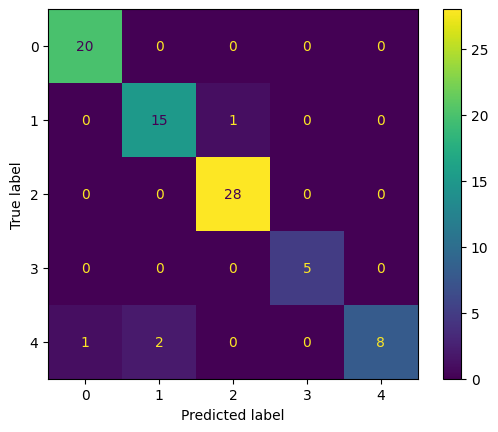

In [56]:
# Model Accuracy
print("F1:", metrics.f1_score(y_test, predicted, average='weighted'))
print("Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Precision:", metrics.precision_score(
    y_test, predicted, average='weighted'))
print("Recall:", metrics.recall_score(y_test, predicted, average='weighted'))

#Ploting the confusion matrix
plt.figure(figsize=(2, 2))
cm = metrics.confusion_matrix(y_test, predicted)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=model.classes_)

disp.plot()


Save and test the model. This pickled model will be used with a server. We do the same for the label encoder. Remember to copy these to the server.

We can look into quantization for reduced model size.

In [74]:
from joblib import dump, load
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

pickled_le = dump(le, './models/labelencoder.joblib')
validate_pickled_le = load('./models/labelencoder.joblib')
pickled_model = dump(model, './models/model.joblib')
validate_pickled_model = load('./models/model.joblib')

xx_test = ["IT recruitment Consultant at SNFHL I'm an IT/SAP recruiter, who likes to learn new stuff and tries some basic coding with SQL in my free time."]

yy_result = validate_pickled_model.predict(xx_test)
yy_result_label = validate_pickled_le.inverse_transform(yy_result)
yy_result_proba = validate_pickled_model.predict_proba(xx_test)

print(f'Predicted: {yy_result_label} at confidece {yy_result_proba[0][yy_result]}\n \
    for features: {validate_pickled_le.inverse_transform(validate_pickled_model.classes_)}\n \
    and their probability: {yy_result_proba}')

/Users/adarmani/miniconda3/envs/hack2023/bin/python
3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
sys.version_info(major=3, minor=9, micro=16, releaselevel='final', serial=0)
Predicted: ['s'] at confidece [0.44828877]
     for features: ['c' 'f' 'o' 's' 'w']
     and their probability: [[0.15848427 0.18118279 0.12618883 0.44828877 0.08585534]]
